# PySpark Data Manipulation- Vietnam War Analysis

### Load Data in Spark Session

In [1]:
!pip install pyspark
from pyspark.sql import SparkSession

# Initialize Spark session
spark = SparkSession.builder.appName("Vietnam_War_Analysis").getOrCreate()


Setting default log level to "WARN".
To adjust logging level use sc.setLogLevel(newLevel). For SparkR, use setLogLevel(newLevel).
24/02/13 10:37:16 WARN NativeCodeLoader: Unable to load native-hadoop library for your platform... using builtin-java classes where applicable


In [2]:
# Load Bombing Operations data
bombing_operations_df = spark.read.json("Bombing_Operations.json")

# Load Aircraft Glossary data
aircraft_glossary_df = spark.read.json("Aircraft_Glossary.json")


In [3]:
bombing_operations_df.show()

+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|AirCraft| ContryFlyingMission|MissionDate|OperationSupported|PeriodOfDay|TakeoffLocation|TargetCountry|TimeOnTarget|          WeaponType|WeaponsLoadedWeight|
+--------+--------------------+-----------+------------------+-----------+---------------+-------------+------------+--------------------+-------------------+
|   EC-47|UNITED STATES OF ...| 1971-06-05|              NULL|          D|   TAN SON NHUT|     CAMBODIA|      1005.0|                NULL|                  0|
|   EC-47|UNITED STATES OF ...| 1972-12-26|              NULL|          D|  NAKHON PHANOM|SOUTH VIETNAM|       530.0|                NULL|                  0|
|    RF-4|UNITED STATES OF ...| 1973-07-28|              NULL|          D|       UDORN AB|         LAOS|       730.0|                NULL|                  0|
|     A-1|UNITED STATES OF ...| 1970-02-02|   

### Calculate count of missions per country

- Using Dataframe Syntax
- Using Spark SQL Syntax
- Using RDD Operation Syntax

In [4]:
# USING DATAFRAME SYNTAX

missions_per_country_df = bombing_operations_df.groupBy("ContryFlyingMission").count()
missions_per_country_df.show()


+--------------------+-------+
| ContryFlyingMission|  count|
+--------------------+-------+
|     VIETNAM (SOUTH)| 622013|
|       KOREA (SOUTH)|  24469|
|UNITED STATES OF ...|3708997|
|           AUSTRALIA|  12519|
|                LAOS|  32777|
+--------------------+-------+



In [5]:
# USING SPARK SQL SYNTAX

bombing_operations_df.createOrReplaceTempView("bombing_operations")
missions_per_country_sql = spark.sql("SELECT ContryFlyingMission, COUNT(*) AS count FROM bombing_operations GROUP BY ContryFlyingMission")
missions_per_country_sql.show()


+--------------------+-------+
| ContryFlyingMission|  count|
+--------------------+-------+
|     VIETNAM (SOUTH)| 622013|
|       KOREA (SOUTH)|  24469|
|UNITED STATES OF ...|3708997|
|           AUSTRALIA|  12519|
|                LAOS|  32777|
+--------------------+-------+



In [6]:
# USING RDD OPERATION SYNTAX

rdd_operations = bombing_operations_df.rdd.map(lambda row: (row.ContryFlyingMission, 1)).reduceByKey(lambda a, b: a + b)
rdd_operations.collect()


[('UNITED STATES OF AMERICA', 3708997),
 ('AUSTRALIA', 12519),
 ('LAOS', 32777),
 ('KOREA (SOUTH)', 24469),
 ('VIETNAM (SOUTH)', 622013)]

### Plot the previously identified count of missiongs by country in a bar chart

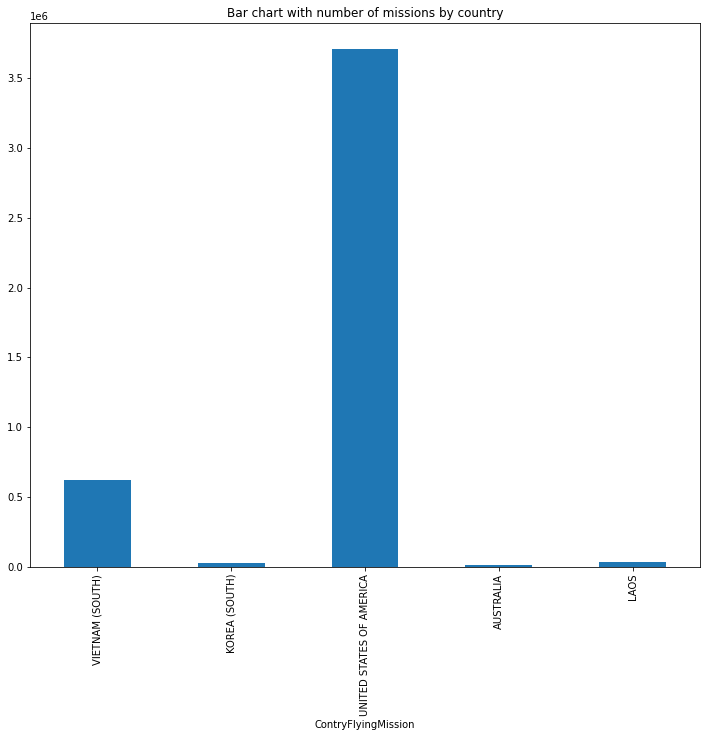

In [7]:
import matplotlib.pyplot as plt

missions_per_country_pd = missions_per_country_df.toPandas()
missions_per_country_pd.plot(kind='bar', x='ContryFlyingMission', y='count', figsize=(12,10), legend=None)
plt.title('Bar chart with number of missions by country')
plt.show()


### Identify and visualize the frequency of Missions conducted by countries over the years.

In [8]:
missions_per_day_per_country = bombing_operations_df.groupBy("ContryFlyingMission", "MissionDate").count()
missions_per_day_per_country_pd = missions_per_day_per_country.toPandas()

In [9]:
missions_per_day_per_country_pd.set_index('MissionDate', inplace=True)


<Axes: title={'center': 'LAOS'}, xlabel='MissionDate'>

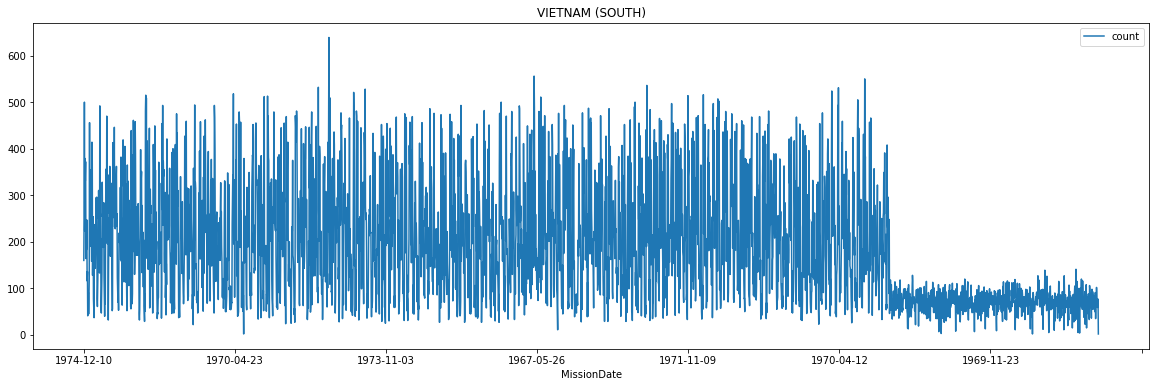

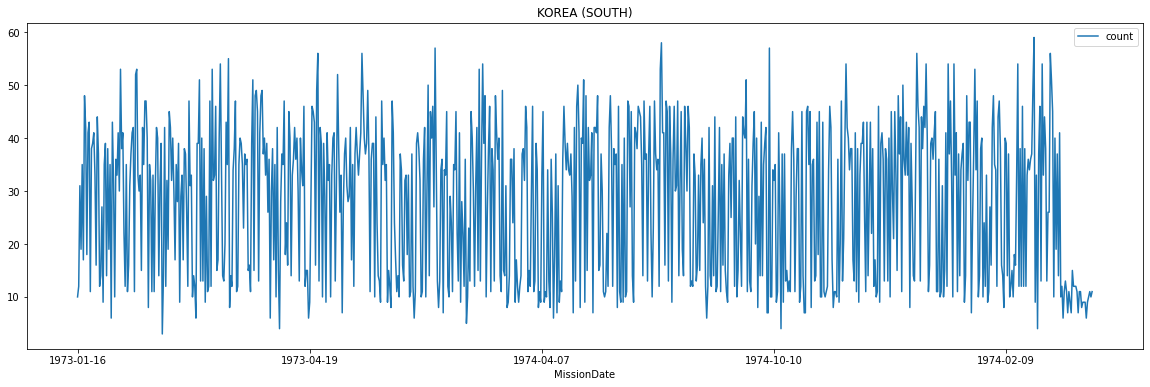

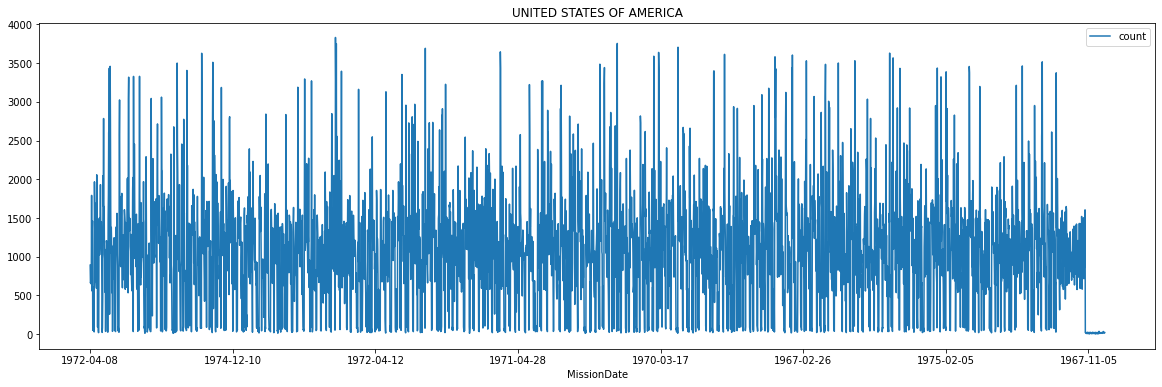

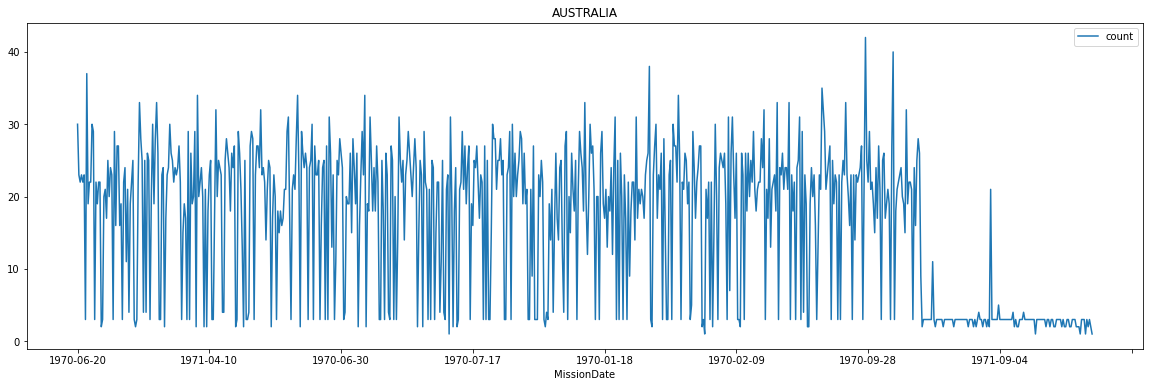

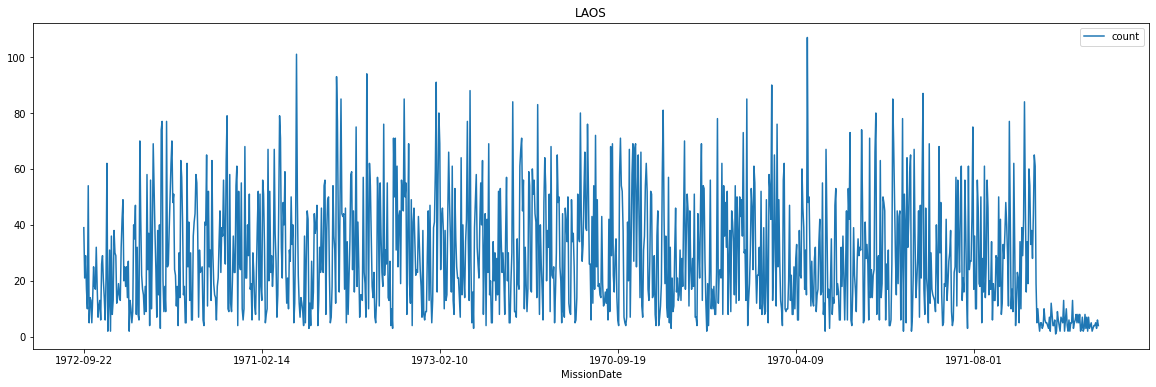

In [10]:
missions_per_day_per_country_pd[missions_per_day_per_country_pd["ContryFlyingMission"] == "VIETNAM (SOUTH)"].plot(title = "VIETNAM (SOUTH)", legend=True, figsize=(20,6))
missions_per_day_per_country_pd[missions_per_day_per_country_pd["ContryFlyingMission"] == "KOREA (SOUTH)"].plot(title="KOREA (SOUTH)", legend=True, figsize=(20,6))
missions_per_day_per_country_pd[missions_per_day_per_country_pd["ContryFlyingMission"] == "UNITED STATES OF AMERICA"].plot(title="UNITED STATES OF AMERICA", legend=True, figsize=(20,6))
missions_per_day_per_country_pd[missions_per_day_per_country_pd["ContryFlyingMission"] == "AUSTRALIA"].plot(title = "AUSTRALIA", legend=True, figsize=(20,6))
missions_per_day_per_country_pd[missions_per_day_per_country_pd["ContryFlyingMission"] == "LAOS"].plot(title="LAOS", legend=True, figsize=(20,6))

### Obtain the frequency of operations launched in North Vietnam on the 29th of June 1996
(Hint: Launching an operation involves the Take Off Location)

In [11]:
takeoffs_on_29_june_1966 = bombing_operations_df.filter((bombing_operations_df.TargetCountry == 'NORTH VIETNAM') & (bombing_operations_df.MissionDate == '1966-06-29'))
takeoffs_by_location = takeoffs_on_29_june_1966.groupBy("TakeoffLocation").count()
takeoffs_by_location.show()


+----------------+-----+
| TakeoffLocation|count|
+----------------+-----+
|    TAN SON NHUT|   26|
|          DANANG|   35|
|        UDORN AB|   44|
|HANCOCK (CVA-19)|   10|
|   CONSTELLATION|   87|
|          TAKHLI|   56|
|          RANGER|   35|
|           KORAT|   55|
|         UBON AB|   44|
|         CUBI PT|    1|
|    CAM RANH BAY|    2|
+----------------+-----+



### Obtain the counts of unique operations conducted and identify the heaviest campaign

In [12]:
heaviest_campaigns = bombing_operations_df.groupBy("OperationSupported").count().orderBy("count", ascending=False)
heaviest_campaigns.show()

+--------------------+-------+
|  OperationSupported|  count|
+--------------------+-------+
|                NULL|1839788|
|          IN COUNTRY| 546215|
|IN COUNTRY - SOUT...| 200616|
|ROLLING THUN - RO...| 197400|
|        ROLLING THUN| 196026|
|         STEEL TIGER| 127572|
|     IN COUNTRY - VS|  77969|
|STEEL TIGER - STE...|  77370|
|         - BLUE TREE|  41893|
|    IN COUNTRY - SVN|  23258|
|BARREL ROLL - BAR...|  22546|
|    STEEL TIGER - LA|  20729|
|         YANKEE TEIM|  16576|
|         BARREL ROLL|  16241|
|STEEL TIGER - COM...|  11945|
|      - LAOS VIETNAM|  10947|
|BARREL ROLL - FIR...|  10821|
|YANKEE TEIM - FALCON|  10721|
|IN COUNTRY - COMB...|  10548|
|IGLOO WHITE - MUS...|   8935|
+--------------------+-------+
only showing top 20 rows



### Identify to the month with the highest number of missions executed

In [13]:
from pyspark.sql.functions import month
import calendar

missions_per_month = bombing_operations_df.groupBy(month("MissionDate").alias("Month")).count().orderBy("count", ascending=False)
highest_month = missions_per_month.first()
month_number = highest_month['Month']
month_name = calendar.month_name[month_number]
count = highest_month['count']
print(f"Month with the highest number of missions: {month_name} ({month_number}) - {count} missions")


Month with the highest number of missions: May (5) - 457431 missions


### Identify the different models of aircrafts used across the missions

In [14]:
most_used_aircraft = bombing_operations_df.groupBy("AirCraft").count().orderBy("count", ascending=False)
most_used_aircraft.show()


+--------+------+
|AirCraft| count|
+--------+------+
|     F-4|909362|
|   F-100|451385|
|     A-4|372975|
|     A-1|358498|
|    A-37|267457|
|    RF-4|242231|
|     A-7|165773|
|    UH-1|146543|
|     A-6|144601|
|   F-105|140410|
|    B-52| 99100|
|    B-57| 82219|
|  AC-119| 76525|
|  AC-130| 75058|
|   AC-47| 73843|
|  RF-101| 71716|
|     F-8| 58691|
|   EC-47| 52865|
|     O-1| 50843|
|    T-28| 41655|
+--------+------+
only showing top 20 rows

